In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patheffects as path_effects
from scipy import stats

sns.set(rc={'figure.figsize': (11.7, 8.27) })
sns.set_theme(palette="pastel")
sns.set_style("ticks")

## Data

[Doc.](https://docs.google.com/document/d/1A9z4in5BycpVx2mMUH2jO8BcO5INyX8QlgTMgyWjfZ0/edit?usp=sharing)

This dataset represents all successful subscription transactions for one of our customer’s stores covering a one-year period from April 2022 through March 2023.
- `invoice_id`: unique identifier for the subscription invoice
- `user_id`: unique identifier for the customer purchasing the subscription
    - NOTE: one user can have multiple invoices, and can subscribe to different plans
- `plan_id`: unique identifier for the subscription plan offered by the store
- `plan_duration`: the length of the purchased subscription period (Monthly or Annual)
- `transaction_date`: date that the invoice was paid
- `subscription_price`: initial price (in USD) on the invoice
- `discount_applied`: the amount (in USD) of any discounts or coupons applied to the subscription price
- `fees_charged`: the amount (in USD) charged in fees on the invoice, including but not limited to subscriber fees charged by Uscreen and/or fees charged for payment processing by a third-party vendor such as Stripe
amount_paid: the amount (in USD) that the store receives for the subscription payment
    - NOTE: use this field when calculating revenue

You can assume that this dataset only includes successful payments, that the subscription period begins on the date that the invoice was successfully paid, and that the store only offers subscription plans (as opposed to also offering one-time purchases, etc.).


In [4]:
df = pd.read_excel('./Example Dataset - Uscreen Data Analyst Assessment.xlsx')
df

,invoice_id,user_id,plan_id,plan_duration,transaction_date,subscription_price,discount_applied,fees_charged,amount_paid
0,ALNtNdnZ5g,jpvAY4jgqX,3ZksraziGv,Monthly,2022-04-01,30,0.0,1.67,28.33
1,UB/p3I3soC,7lnc9S0e+k,3ZksraziGv,Monthly,2022-04-01,30,0.0,1.97,28.03
2,JPqaABdS9/,rSRvTF4HKP,3ZksraziGv,Monthly,2022-04-01,30,0.0,1.67,28.33
3,qFP1t+jHi2,2P8ziCzzMW,3ZksraziGv,Monthly,2022-04-01,30,0.0,1.67,28.33
4,/RBlpp5X7q,i677ChXxOx,3ZksraziGv,Monthly,2022-04-01,30,0.0,1.67,28.33
...,...,...,...,...,...,...,...,...,...
16002,qdHKVKAOhF,VSq893sNRI,3ZksraziGv,Monthly,2023-03-31,30,0.0,1.67,28.33
16003,hLw6HBb9m+,uw2jc4WWsE,3ZksraziGv,Monthly,2023-03-31,30,0.0,1.67,28.33
16004,dKhjtWK32q,EVWM9/6DCR,3ZksraziGv,Monthly,2023-03-31,30,0.0,1.67,28.33
16005,xtkGmu68Kx,mqoV9w5vMG,3ZksraziGv,Monthly,2023-03-31,30,10.0,1.58,18.42


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16007 entries, 0 to 16006
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   invoice_id          16007 non-null  object        
 1   user_id             16007 non-null  object        
 2   plan_id             16007 non-null  object        
 3   plan_duration       16007 non-null  object        
 4   transaction_date    16007 non-null  datetime64[ns]
 5   subscription_price  16007 non-null  int64         
 6   discount_applied    16007 non-null  float64       
 7   fees_charged        16007 non-null  float64       
 8   amount_paid         16007 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 1.1+ MB


In [9]:
df.describe()

,transaction_date,subscription_price,discount_applied,fees_charged,amount_paid
count,16007,16007.000000,16007.000000,16007.000000,16007.000000
mean,2022-10-06 02:57:56.529018880,43.377272,1.659274,2.627620,39.090379
min,2022-04-01 00:00:00,30.000000,0.000000,-30.000000,12.960000
25%,2022-07-06 12:00:00,30.000000,0.000000,1.670000,27.360000
50%,2022-10-11 00:00:00,30.000000,0.000000,1.970000,28.330000
75%,2023-01-08 00:00:00,30.000000,0.000000,2.640000,28.330000
max,2023-03-31 00:00:00,275.000000,77.000000,50.660000,275.000000
std,NaN,55.665734,10.176200,3.529466,47.272154


In [16]:
df['invoice_id'].nunique()

16007

In [18]:
df['plan_id'].value_counts()

plan_id
3ZksraziGv    15133
4tWDsR5/vb      874
Name: count, dtype: int64

In [115]:
df[['plan_id', 'plan_duration', 'subscription_price']].value_counts()

# We seem to have plan_id-plan_duration_subscription_price as a one-to-one relationship:
# i.e. there is only one Monthly and Annual plan with only one price.

plan_id     plan_duration  subscription_price
3ZksraziGv  Monthly        30                    15133
4tWDsR5/vb  Annual         275                     874
Name: count, dtype: int64

## Questions
### Question 1
The store owners are curious to learn more about the discounts they offered this past year. What % of the paid invoices have had discounts applied, and what is the total amount of $ discounted?




In [74]:
df['had_discount'] = df['discount_applied'] > 0.0

# perc_of_distounted_invoces = df['had_discount'].value_counts(normalize=True).to_dict()[True]
num_of_distounted_invoces = (df['had_discount']
    .value_counts()
    .to_dict()[True]
)

num_of_all_invoces = df.shape[0]
perc_of_distounted_invoces = num_of_distounted_invoces / num_of_all_invoces

total_amount_distounted = df['discount_applied'].sum()

print(
"""
{:.2%} of paid invoces have had discounts applied ({} out of {}).
Total amount discounted is ${:,}.
""".format(
        perc_of_distounted_invoces,
        num_of_distounted_invoces,
        num_of_all_invoces,
        total_amount_distounted
    )
)


4.17% of paid invoces have had discounts applied (668 out of 16007).
Total amount discounted is $26,560.0.



### Question 2

The store owners want to explore opportunities to convert monthly customers onto annual plans to secure more revenue upfront. What is the total # of users that subscribed to both a monthly and annual plan this past year?

In [80]:
user_counts_per_num_of_plan_durations = (df
     .groupby('user_id')
     ['plan_duration']
     .nunique()
     .value_counts()
)

user_count_two_plan = user_counts_per_num_of_plan_durations[2]
user_count_total = user_counts_per_num_of_plan_durations.sum()

print(
"""
Total # of users of users that subscribed to both a monthly and annual plan this past year is {} (out of {} amounting to {:.2%}).
""".format(
        user_count_two_plan,
        user_count_total,
        user_count_two_plan / total_user_count
    )
)


Total # of users of users that subscribed to both a monthly and annual plan this past year is 107 (out of 3619 amounting to 2.96%).



### Question 3

What % of the store’s revenue in 2023 to date is from annual subscriptions? How does that compare to 2022? 

In [160]:
df['transaction_year'] = df['transaction_date'].dt.year

revenue_per_year = (df
    .groupby(['transaction_year', 'plan_duration'])
    ['fees_charged']
    .sum()
    .unstack() # Moving Annual and Monthly of the same year to one row.
)

revenue_per_year['Total'] = revenue_per_year['Annual'] + revenue_per_year['Monthly']
revenue_per_year['annual_percentage'] = revenue_per_year['Annual'] / revenue_per_year['Total']

print(
"""
In 2023 {:.2%} of revenue came from annual subscriptions.
Compared to 2022's {:.2%} it grew {:.2f} times.
""".format(
        revenue_per_year.loc[2023, 'annual_percentage'],
        revenue_per_year.loc[2022, 'annual_percentage'],
        revenue_per_year.loc[2023, 'annual_percentage'] / revenue_per_year.loc[2022, 'annual_percentage']
    )
)


In 2023 45.92% of revenue came from annual subscriptions.
Compared to 2022's 26.26% it grew 1.75 times.



In [117]:
df.columns

Index(['invoice_id', 'user_id', 'plan_id', 'plan_duration', 'transaction_date',
       'subscription_price', 'discount_applied', 'fees_charged', 'amount_paid',
       'had_discount', 'transaction_year'],
      dtype='object')

### Question 4

One idea the store owners are exploring is to offer a discounted annual upgrade for their most loyal monthly customers; what are the user IDs of the customers that subscribed to the monthly plan for all of the past 12 months?

In [157]:
# df['transaction_date'].dt.month.nunique() #12, we good.
df['transaction_month'] = df['transaction_date'].dt.month

users_with_num_of_months = (df
    [df['plan_duration'] == 'Monthly']
    .groupby('user_id')
    ['transaction_month']
    .nunique()
)

m_loyal_users = users_with_num_of_months[users_with_num_of_months == 12].index.to_list()

m_user_count_total = users_with_num_of_months.shape[0]
m_user_count_loyal = len(m_loyal_users)
m_user_perc_loyal = m_user_count_loyal / m_user_count_total

print("""
Out of all {} customers that subscribed to the monthly plan, {} did so for all of the past 12 months ({:.2%}).

Their user IDs are:\n{}
""".format(
        m_user_count_total,
        m_user_count_loyal,
        m_user_perc_loyal,
        m_loyal_users
    )
)


Out of all 2852 customers that subscribed to the monthly plan, 531 did so for all of the past 12 months (18.62%).

Their user IDs are:
['+4az0TH3/7', '+FO0nE28dX', '+Fk45O9ScR', '+O1YUKL3kd', '+e88xxEJvO', '+jAVQeMN4F', '+so5GmbQPP', '+y48ebzdwP', '//cjzQMmXr', '/AO2TXfL3Q', '/EuovQCpbQ', '/JxHJuGMZ2', '/P+vKGJUb/', '/YRf1ZxoQi', '/fL2KJDR/S', '/fuSyKprcL', '/xcnbglZ6e', '0/bPj8ABG7', '053Mdt7Jf7', '08VVYGDaRZ', '0AbztCXisl', '0E6YawZVek', '0JdDKmRChR', '0Lez+GRUIa', '0SxQCGkOXt', '0Tjx0OQobk', '0bXY+TcAza', '0tefujpqZo', '135lC52rqS', '1N9+8z0SiS', '1PThgAlWaw', '1Taxgjs8eB', '1oMpEpIa1S', '1tFD6r6eF7', '1ve2Fsi48K', '27pQTKo/A4', '2Mby/BHSnl', '2d5V7R5eJO', '3+R7CpD8nz', '36Hv4ixnsZ', '3FmW0mXOyD', '3HYbAh8TN3', '3ZZyz/yrNy', '3gCmOMPEmV', '3gLiF2dy1O', '3i/WnjYTYI', '3vXc/67AXW', '3zRuwDypcw', '45pUcK32S8', '4AgP6+Gey9', '4JCEqjNCCI', '4OReAQCK8c', '4bfEy1xAir', '4bopMr7Af5', '4ek5CJgBGa', '4fB2satng3', '4iouqcUgTk', '4j36GbUCAU', '4oBfzhRSRk', '4sPHHoffs/', '5DrcNheA2F', '5FemVjDT

### Question 5

The store is trying to understand if they are doing better or worse at early retention of monthly customers over time. Grouped by the month of their first paid invoice, what % of new monthly customers renew in the following month? Share a table or chart with your results along with a written response to share with the customer about your observations. 

In [282]:
df_monthly = df[df['plan_duration'] == 'Monthly'].copy()
df_monthly['transaction_period_m'] = df_monthly['transaction_date'].dt.to_period('M')

user_min_month = (df_monthly
    .groupby('user_id')
    ['transaction_period_m']
    .min()
)

user_months = (df_monthly
    .groupby(['user_id', 'transaction_period_m'])
    .size()
    .reset_index()
    .drop([0], axis=1)
)

user_months_cross = user_months.merge(
    right=user_months,
    on='user_id',
    suffixes=('0', '1')
)
                     
user_months_cross = (user_months_cross
    [user_months_cross['transaction_period_m0'] <= user_months_cross['transaction_period_m1']]
)

month_over_month_counts = (user_months_cross
    .groupby(['transaction_period_m0', 'transaction_period_m1'])
    ['user_id']
    .nunique()
    .reset_index()
)

In [291]:
retention = ((month_over_month_counts[
    (month_over_month_counts['transaction_period_m0'] == month_over_month_counts['transaction_period_m1'])
    ]
    ).merge(right=month_over_month_counts[
        (month_over_month_counts['transaction_period_m0'] + 1 == month_over_month_counts['transaction_period_m1'])
        ],
        on='transaction_period_m0',
        suffixes=('0', '1')
    )[['transaction_period_m0', 'user_id0', 'user_id1']]
    .rename(columns={
        'transaction_period_m0': 'month',
        'user_id0': 'starting_users',
        'user_id1': 'remaining_users'
    })
)

retention['remaining_users_perc'] = retention['remaining_users'] / retention['starting_users']
retention

,month,starting_users,remaining_users,remaining_users_perc
0,2022-04,1275,1106,0.867451
1,2022-05,1232,1096,0.889610
2,2022-06,1228,1107,0.901466
3,2022-07,1232,1094,0.887987
4,2022-08,1211,1086,0.896780
5,2022-09,1206,1055,0.874793
6,2022-10,1175,1021,0.868936
7,2022-11,1247,1032,0.827586
8,2022-12,1283,1081,0.842557
9,2023-01,1301,1093,0.840123


In [292]:
retention.describe()

,starting_users,remaining_users,remaining_users_perc
count,11.000000,11.000000,11.000000
mean,1239.181818,1078.818182,0.870950
std,36.512513,29.518869,0.024605
min,1175.000000,1021.000000,0.827586
25%,1219.500000,1068.000000,0.855004
50%,1232.000000,1093.000000,0.874793
75%,1261.000000,1096.000000,0.888799
max,1301.000000,1107.000000,0.901466


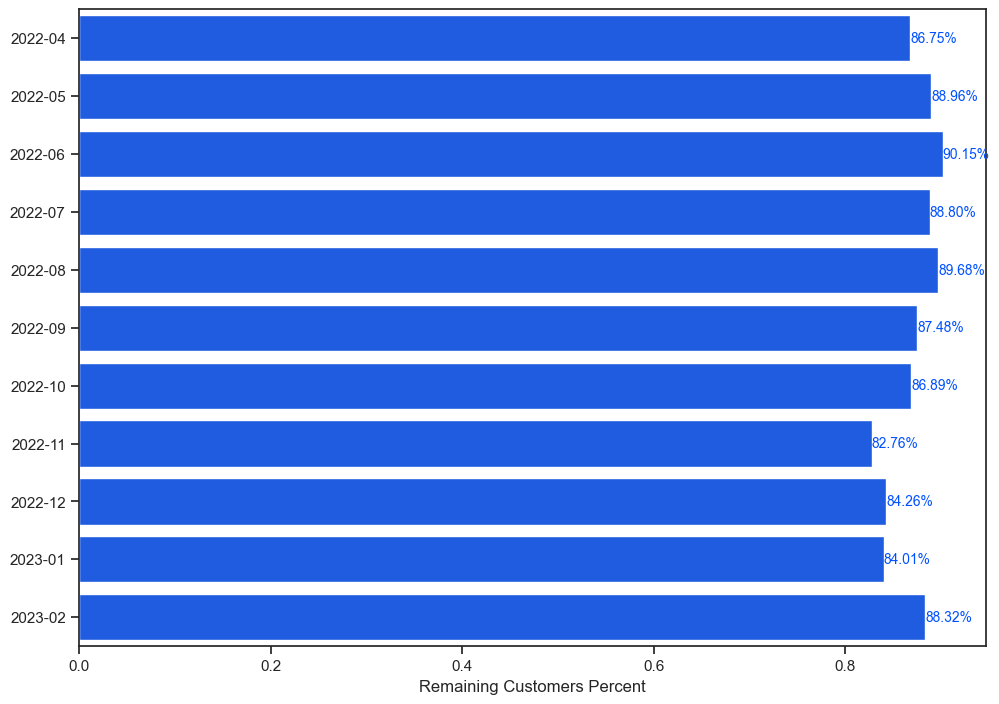

In [343]:
blue = '#0050ff'
ax = sns.barplot(
    data=retention,
    y='month',
    x='remaining_users_perc',
    color=blue
)

ax.set(xlabel="Remaining Customers Percent", ylabel="")
ax.bar_label(
    ax.containers[0],
    fontsize=10,
    fmt='{:.2%}',
    color=blue
);

Not very interesting: the percent of new monthly customers that renew in the following month is stable around the average of **87.10%**.

Let us see if retention over longer spans provides insights. 

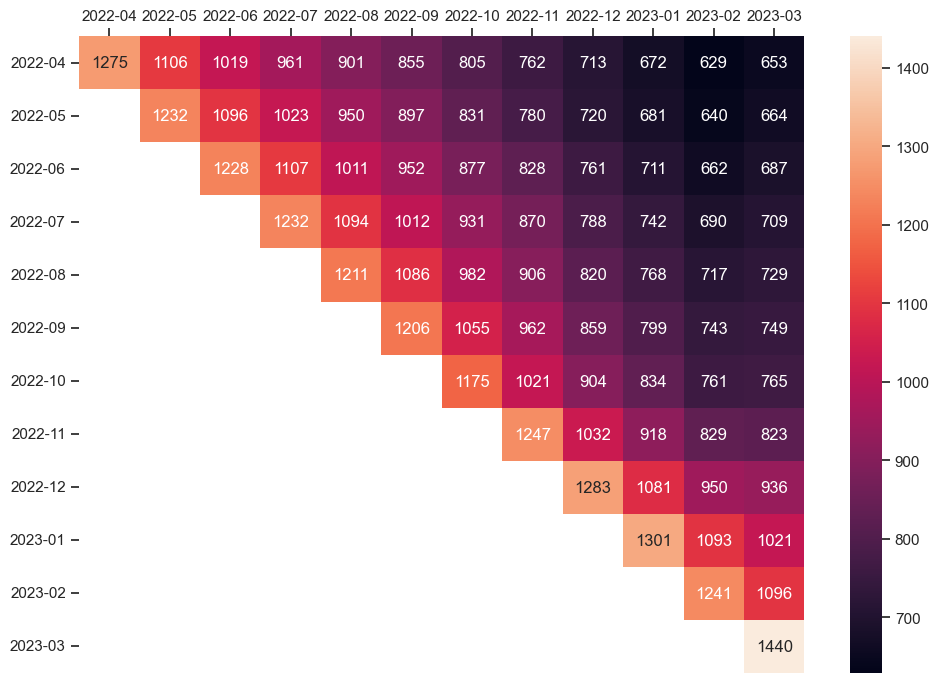

In [303]:
month_over_month_counts_pivoted = month_over_month_counts.pivot(
        index='transaction_period_m0',
        columns='transaction_period_m1',
        values='user_id'
    )

ax = sns.heatmap(
    data=month_over_month_counts_pivoted,
    annot=True,
    fmt=".0f"
)

ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

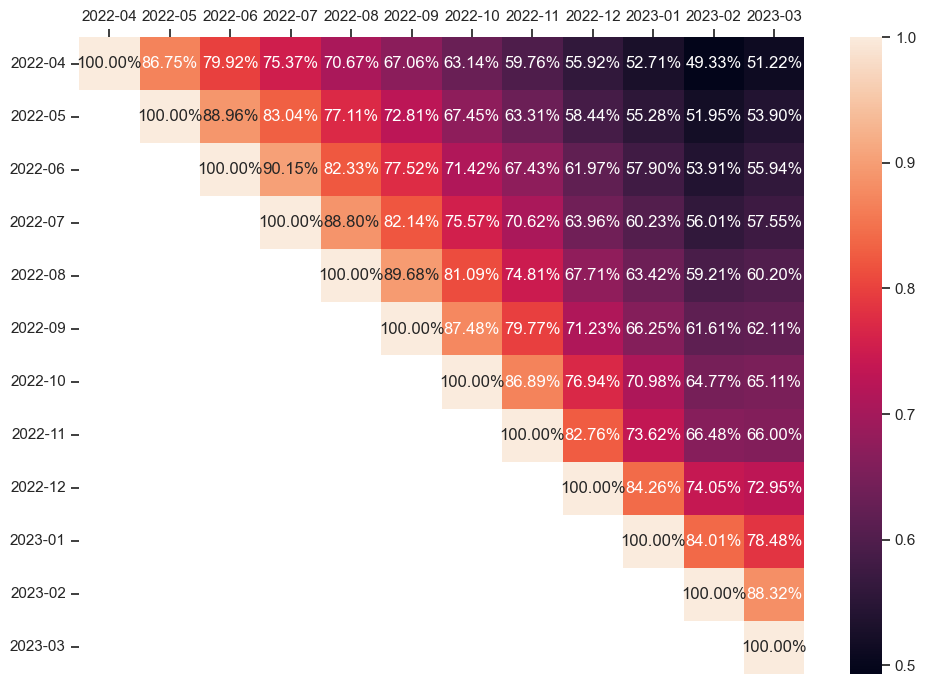

In [346]:
# And now percentage row-wise.

month_over_month_counts_pivoted_perc = month_over_month_counts_pivoted.apply(lambda x: x / max(x.fillna(0)), axis=1)

ax = sns.heatmap(
    data=month_over_month_counts_pivoted_perc,
    annot=True,
    fmt='.2%'
)

ax.set(xlabel='', ylabel='')
ax.xaxis.tick_top()

The first month retention is **87.10%** on average.

On the graph we can see that:
1. For the 4 months from 2022-05 to 2022-08 first month retention was distinctly **above average**.
2. For the 3 months from 2022-11 to 2023-01 first month retention was distinctly **below average**
3. Retention over longer spans tends to **approximately 53%**.
4. It is not uncommon for users to **reactivate**: column of 2023-03 has a lot of entries that have more users than the 2023-02 one.
5. The **second and third** month are the moments when retention on average suffers the steepest drop.


### Question 6
What other recommendations would you make to the store owners on ways they could convert more customers onto annual subscriptions? What additional data (if any) would you want to analyze to help make such a recommendation?

In [358]:
func_list = ['min', 'mean', 'max']
plan_stats = (df
     .groupby('plan_duration')
     [['user_id', 'subscription_price', 'discount_applied', 'amount_paid']]
     .agg(
         {
             'user_id' : 'nunique',
             'subscription_price': func_list,
             'discount_applied': func_list,
             'amount_paid': func_list
         }
     )
)

plan_stats.loc['Monthly12'] = plan_stats.loc['Monthly'] * 12
plan_stats

user_id subscription_price               discount_applied  \
               nunique                min   mean    max              min   
plan_duration                                                              
Annual           874.0              275.0  275.0  275.0              0.0   
Monthly         2852.0               30.0   30.0   30.0              0.0   
Monthly12      34224.0              360.0  360.0  360.0              0.0   

                                amount_paid                     
                    mean    max         min        mean    max  
plan_duration                                                   
Annual         26.480549   77.0      177.67  232.839428  275.0  
Monthly         0.225732   30.0       12.96   27.900484   30.0  
Monthly12       2.708782  360.0      155.52  334.805812  360.0

In [372]:
monthly_fee = 30.0
annual_fee = 275.0
yearly_fee_monthly = 12 * monthly_fee

diff = yearly_fee_monthly - annual_fee
diff_perc = diff / yearly_fee_monthly

print(
"""
Since I get a feeling that the difference in prices is not getting advertised enough
(bonus is so big, yet it is used so rarely), I would recommend informing the customers in the following manner:


You can buy yearly now for only ${}.
That will save you ${} which is basically {:.2%} off or almost {} months for free!

What are you waiting for?
""".format(
        annual_fee,
        # monthly_fee,
        diff,
        diff_perc,
        round(diff / monthly_fee)
    )
)


Since I get a feeling that the difference in prices is not getting advertised enough
(bonus is so big, yet it is used so rarely), I would recommend informing the customers in the following manner:


You can buy yearly now for only $275.0.
That will save you $85.0 which is basically 23.61% off or almost 3 months for free!

What are you waiting for?



> What additional data (if any) would you want to analyze to help make such a recommendation?

1. It would be helpful to know what **exactly** this business does. Finance data is good, but not necessarily enough for a thorough analysis.
2. Some usage data would be appreciated: some patterns of usage (or lack thereof) might be more associated with churn or retention — finding that would give us something to look out or strive for.
3. User data would also be good:
    1. payment system,
    2. country,
    3. email domain (to categorize as generic/business/education),
    4. signup date,
    5. signup source (channel),
    6. any other piece of data you gather that might be helpful in forming user groups that can be meaningfully compared.